# Token Level Analysis

In [52]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json

In [ ]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

validation_tasks = json_object['val']


## Code for generating task level analysis.

General task information:


=== Task 25ff71a9 Program ===
x1 = objects(I, T, T, T)
x2 = first(x1)
O = move(I, x2, DOWN)


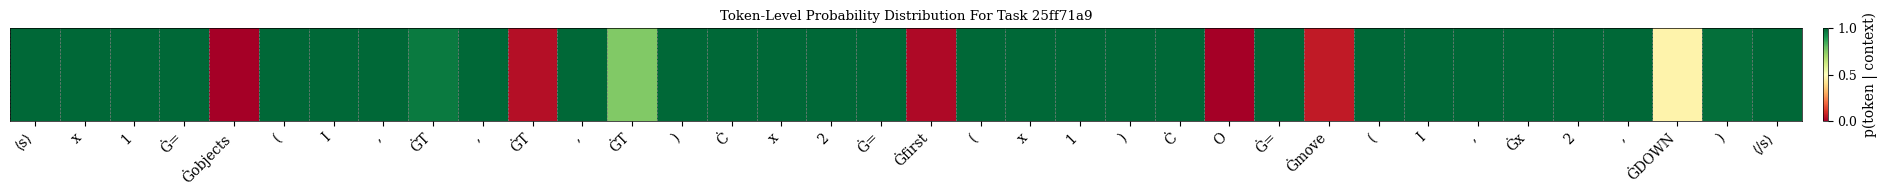

In [44]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task


def output_program_lines(task):
    print(f"=== Task {task.task_key} Program ===")

    print(task.program_lines)


def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    # teacher-forcing forward pass
    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
    
    log_p     = torch.log_softmax(logits, -1)

    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return tokens, p_token

def output_correct_token_probs(task_id, tokens, p_token): 
    fig, ax = plt.subplots(figsize=(len(tokens) * 0.6, 2))
    im = ax.imshow(np.array([p_token]), aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    ax.set_yticks([])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(display_tokens, rotation=45, ha="right", fontsize=10)
    
    ax.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    plt.title(f"Token-Level Probability Distribution For Task {task_id}")
    plt.tight_layout()
    plt.show()

def generate_task_level_analysis(task_id, model_path='../finetune-checkpoint/dev-checkpoint'): 
    task = Task.from_json(f'../data/training/{task_id}.json')
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    output_program_lines(task)
    tokens, p_token = compute_logits(task, model)
    output_correct_token_probs(task.task_key, tokens, p_token)

    # compute entropies of correct ones.


generate_task_level_analysis(validation_tasks[8])

Training specific plots:

## Code for Generating Dataset Level Token Prob Stats


Code for generating dataset wide heat map.


Forward-passes:   0%|          | 0/89 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


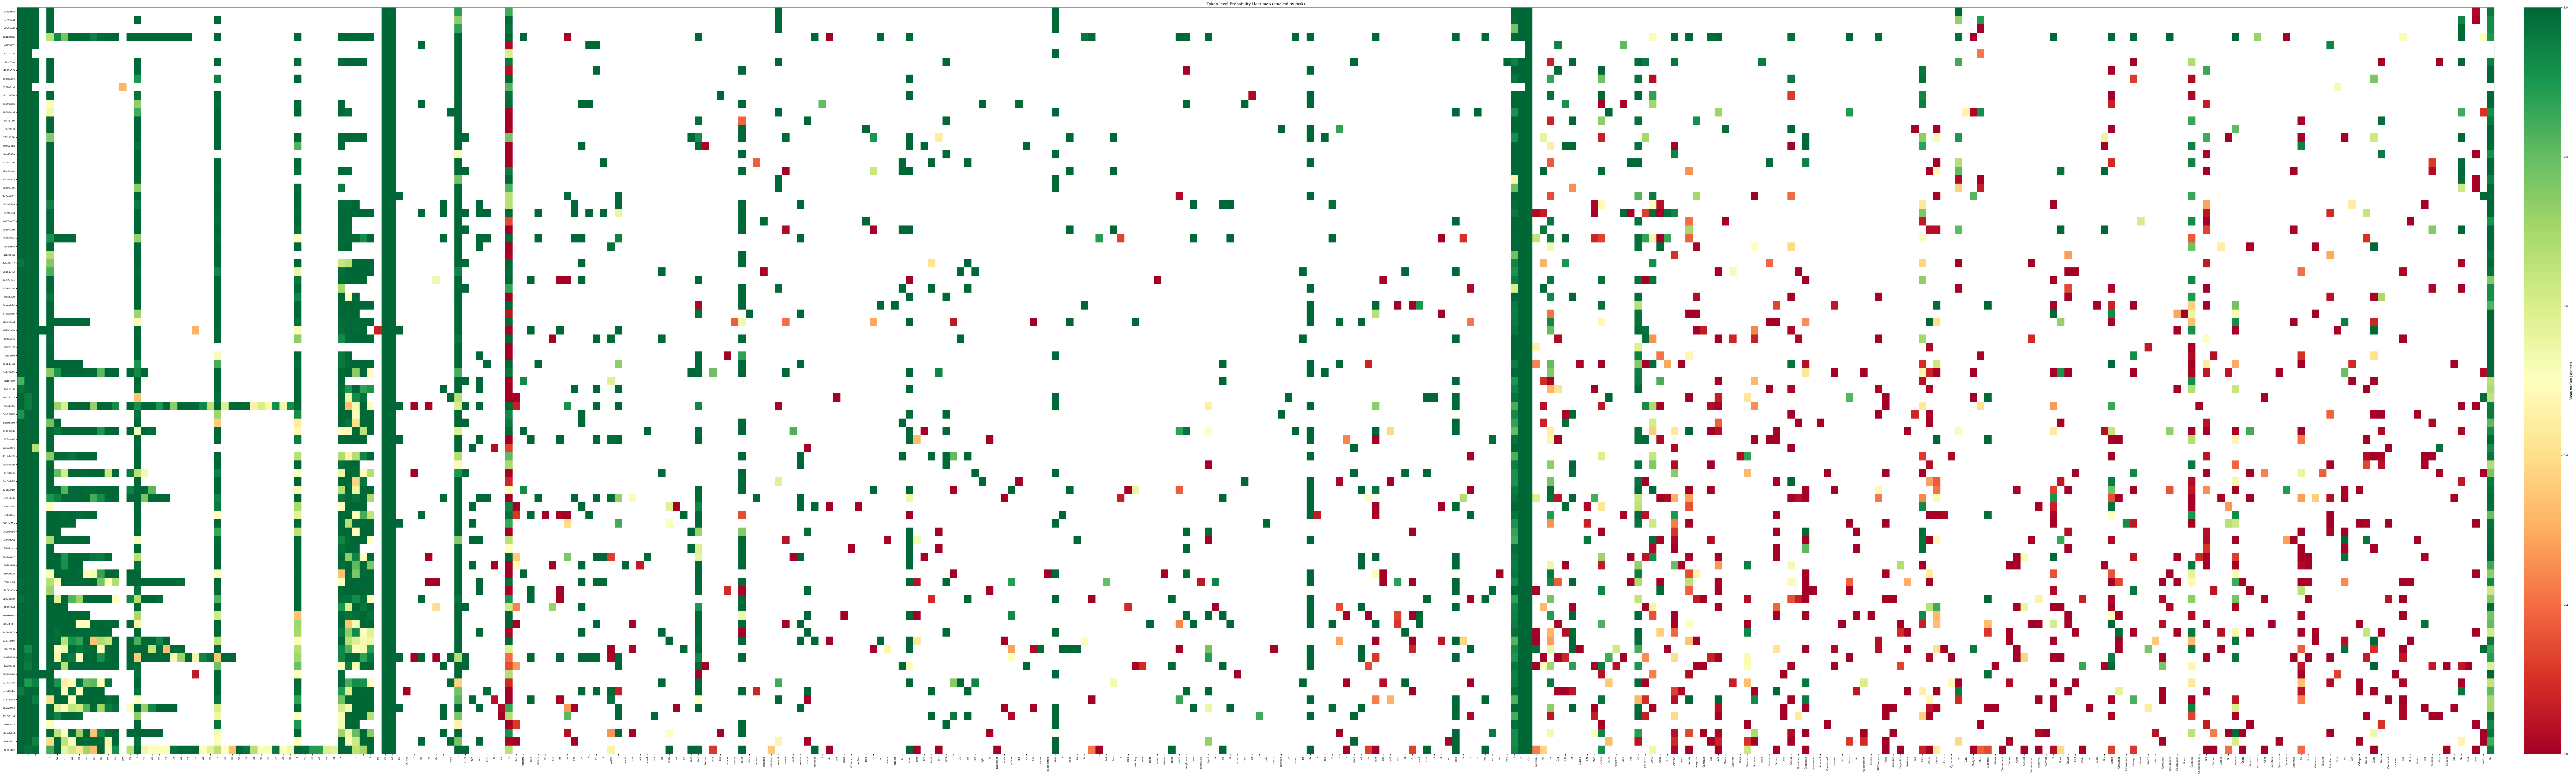

In [47]:
 

from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

 
def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits          # [1, seq_len, vocab]

    log_p = torch.log_softmax(logits, -1)
    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token = token_logp.exp().squeeze().tolist()            # list[float]

    tokens = tokenizer.convert_ids_to_tokens(ids[0])         # list[str]
    return tokens, p_token

def collect_per_task_stats(task_ids,
                           model_path='../finetune-checkpoint/dev-checkpoint',
                           tokenizer_name='Salesforce/codet5p-220m',
                           data_root='../data/training',
                           min_occurrences=1):
 
    tok   = AutoTokenizer.from_pretrained(tokenizer_name)
    model = T5ForConditionalGeneration.from_pretrained(model_path)\
                                      .to('cuda' if torch.cuda.is_available() else 'cpu')

    # global token set
    all_tokens = set()

    # first pass: gather per-task token→list(prob) dicts
    per_task_probs = []
    task_keys      = []

    for tid in tqdm(task_ids, desc="Forward-passes"):
        task   = Task.from_json(f'{data_root}/{tid}.json')
        tokens, p_token = compute_logits(task, model, tok)

        mapping = defaultdict(list)
        for t, p in zip(tokens, p_token):
            mapping[t].append(p)
            all_tokens.add(t)
        per_task_probs.append(mapping)
        task_keys.append(tid)

    # fix token order for columns
    tokens_sorted = sorted(all_tokens)
    tok_index     = {t:i for i,t in enumerate(tokens_sorted)}

    # build matrix
    n_tasks  = len(task_ids)
    n_tokens = len(tokens_sorted)
    prob_mat = np.full((n_tasks, n_tokens), np.nan, dtype=np.float32)

    for row, mapping in enumerate(per_task_probs):
        for t, ps in mapping.items():
            if len(ps) >= min_occurrences:
                prob_mat[row, tok_index[t]] = np.mean(ps)

    return tokens_sorted, task_keys, prob_mat

 
def plot_stacked_heatmap(tokens_sorted, task_keys, prob_mat,
                         sort_by=None,   # "mean" | "entropy" | None
                         cmap='RdYlGn', vmin=0, vmax=1):
   
    mat = prob_mat.copy()

    # optional sorting
    if sort_by == "mean":
        order = np.nanmean(mat, axis=1).argsort()[::-1]  # high→low
        mat   = mat[order];   task_keys = [task_keys[i] for i in order]
    elif sort_by == "entropy":
        ent   = -(mat * np.log(mat)).sum(axis=1, where=~np.isnan(mat))
        order = np.argsort(ent)[::-1]
        mat   = mat[order];   task_keys = [task_keys[i] for i in order]

    # plotting
    fig_h = max(4, 0.35 * len(task_keys))
    fig_w = max(6, 0.35 * len(tokens_sorted))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(mat, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    # x-axis: tokens
    ax.set_xticks(range(len(tokens_sorted)))
    ax.set_xticklabels(
        [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens_sorted],
        rotation=90, ha='center', fontsize=7
    )

    # y-axis: task keys
    ax.set_yticks(range(len(task_keys)))
    ax.set_yticklabels(task_keys, fontsize=7)

    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label('Mean $p$(token | context)', fontsize=9)

    plt.title('Token-level Probability Heat-map (stacked by task)', fontsize=11)
    plt.tight_layout()
    plt.show()

tokens_sorted, task_keys, prob_mat = collect_per_task_stats(
    validation_tasks,
    model_path='../finetune-checkpoint/dev-checkpoint'
)

plot_stacked_heatmap(tokens_sorted, task_keys, prob_mat, sort_by="mean")


Forward-passes:   0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


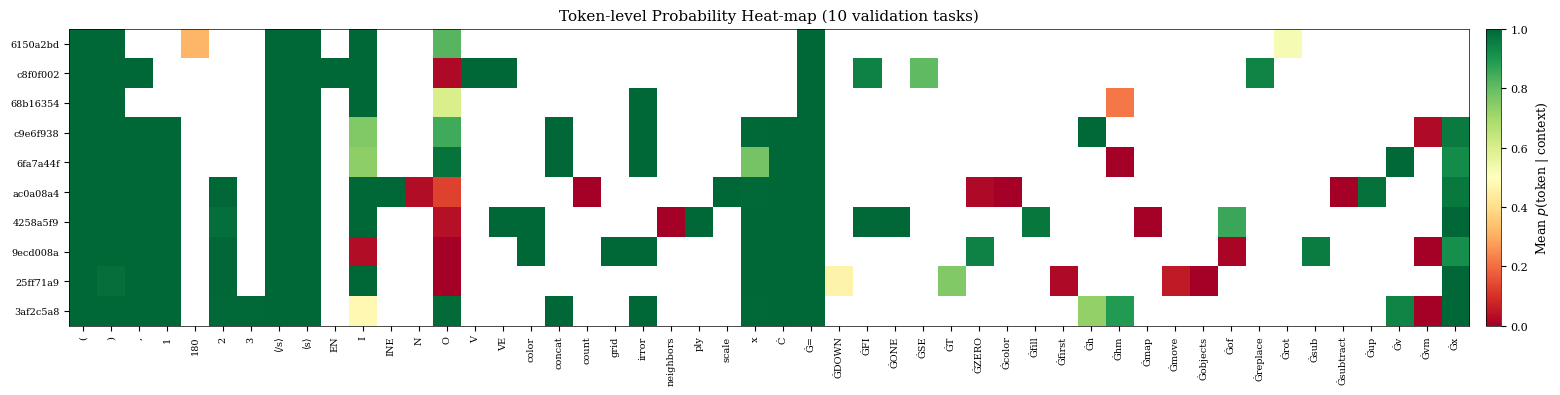

In [50]:
 

from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
 
tasks_subset = validation_tasks[:10]       

 
def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = tokenizer.convert_ids_to_tokens(ids[0])

    return tokens, p_token

 
def collect_stats_subset(task_ids,
                         model_path='../finetune-checkpoint/dev-checkpoint',
                         tokenizer_name='Salesforce/codet5p-220m',
                         data_root='../data/training'):
    tok   = AutoTokenizer.from_pretrained(tokenizer_name)
    model = T5ForConditionalGeneration.from_pretrained(model_path)\
                                      .to('cuda' if torch.cuda.is_available() else 'cpu')

    token_set      = set()
    per_task_probs = []
    task_keys      = []

    # forward passes
    for tid in tqdm(task_ids, desc="Forward-passes"):
        task   = Task.from_json(f'{data_root}/{tid}.json')
        tokens, p_token = compute_logits(task, model, tok)

        mapping = dict(zip(tokens, p_token))     # one value per token position
        per_task_probs.append(mapping)
        task_keys.append(tid)
        token_set.update(tokens)

    # build matrix (rows = tasks, cols = tokens that appear ≥ once)
    tokens_sorted = sorted(token_set)
    tok_index     = {t: i for i, t in enumerate(tokens_sorted)}

    n_tasks, n_tokens = len(task_ids), len(tokens_sorted)
    mat = np.full((n_tasks, n_tokens), np.nan, dtype=np.float32)

    for row, mapping in enumerate(per_task_probs):
        for t, p in mapping.items():
            mat[row, tok_index[t]] = p   # only those tokens present in this task

    # drop columns that are still all-NaN (shouldn’t happen, but safe)
    keep_cols = ~np.isnan(mat).all(axis=0)
    tokens_sorted = [t for t, keep in zip(tokens_sorted, keep_cols) if keep]
    mat = mat[:, keep_cols]

    return tokens_sorted, task_keys, mat

 
def plot_heatmap(tokens_sorted, task_keys, prob_mat,
                 cmap='RdYlGn', vmin=0, vmax=1):
    fig_h = max(4, 0.35 * len(task_keys))
    fig_w = max(6, 0.35 * len(tokens_sorted))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(prob_mat, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    # x-axis: tokens
    ax.set_xticks(range(len(tokens_sorted)))
    ax.set_xticklabels(
        [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩")
         for t in tokens_sorted],
        rotation=90, ha='center', fontsize=7
    )

    # y-axis: task IDs
    ax.set_yticks(range(len(task_keys)))
    ax.set_yticklabels(task_keys, fontsize=7)

    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label('Mean $p$(token | context)', fontsize=9)

    plt.title('Token-level Probability Heat-map (10 validation tasks)', fontsize=11)
    plt.tight_layout()
    plt.show()

tokens_sorted, task_keys, prob_mat = collect_stats_subset(tasks_subset)
plot_heatmap(tokens_sorted, task_keys, prob_mat)


## Entropy et al analysis.

In [ ]:
import torch, math


def token_stats(logits, ids):
    log_p = torch.log_softmax(logits, -1)           # [1, L, V]
    probs = log_p.exp()

    entropy = -(probs * log_p).sum(-1).squeeze(0)   # [L]  (nats)

    # top-1 correctness
    top1_ids = logits.argmax(-1)                    # [1, L]
    is_correct = (top1_ids == ids).float().squeeze(0)

    p_true = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)

    return entropy.cpu(), is_correct.cpu(), p_true.cpu()
    


def gather_val_records(val_tasks, tok, model, score_kind="entropy",
                       cache_file=None, batch_size=4):
    model.eval()
    ent_list, err_list = [], []

    for task in tqdm.tqdm(val_tasks, desc=f"val ({score_kind})"):
        src_ids = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)
        tgt_ids = tok(task.program_lines,
                      return_tensors="pt").input_ids
        src_ids, tgt_ids = src_ids.to(model.device), tgt_ids.to(model.device)

        with torch.no_grad():
            logits = model(src_ids, labels=tgt_ids).logits  # [1, L, V]

        score   = token_score(logits, tgt_ids, kind=score_kind)
        correct = (logits.argmax(-1).squeeze(0) == tgt_ids.squeeze(0)).float()

        ent_list.extend(score.tolist())
        err_list.extend((1.0 - correct).tolist())           # 1 = error

    return ent_list, err_list 



import torch

def token_score(logits: torch.Tensor,           # [1, L, V]
                ids: torch.Tensor | None = None,# [1, L]  (needed only for "nll")
                kind: str = "entropy") -> torch.Tensor:
   
    log_p = torch.log_softmax(logits, -1)           # [1, L, V]
    probs = log_p.exp()                             # [1, L, V]

    if kind == "entropy":                          
        score = -(probs * log_p).sum(-1).squeeze(0)

    elif kind == "nll":
        if ids is None:
            raise ValueError("ids required for kind='nll'")
        score = -log_p.squeeze(0) \
                   .gather(1, ids.squeeze(0).unsqueeze(1)) \
                   .squeeze(1)                      # -log p_true

    elif kind in ("1-pmax", "neglog_pmax"):
        p_max = probs.max(-1).values.squeeze(0)     # [L]
        score = 1.0 - p_max if kind == "1-pmax" else -p_max.log()

    elif kind == "margin":
        top2 = probs.topk(2, -1).values.squeeze(0)  # [L, 2]
        score = -(top2[:, 0] - top2[:, 1])          # negative margin

    elif kind == "logit_margin":
        z_top2 = logits.squeeze(0).topk(2, -1).values  # [L, 2]
        score = -(z_top2[:, 0] - z_top2[:, 1])

    elif kind == "energy":
        score = torch.logsumexp(logits, -1).squeeze(0)

    else:
        raise ValueError(f"Unknown score kind: {kind}")

    return score.detach().cpu()                    # [L] on CPU


def recall_at_tau(entropy, is_error, tau):
    ent = torch.tensor(entropy)
    err = torch.tensor(is_error).bool()
    tp  = ((ent > tau) & err).sum()
    fn  = ((ent <= tau) & err).sum()
    return (tp / (tp + fn + 1e-9)).item()          # avoid 0-div


def entropy_reliability(records, recall_target=0.95, tau=0.5):
      ent, err = zip(*records)               # lists of floats / ints
      ent = torch.tensor(ent)
      err = torch.tensor(err)                # 1 = error, 0 = correct

      print(f"Recall @ τ={tau} bits : {recall_at_tau(ent, err, tau):.3f}")
      # ROC-AUC
      auc_roc = roc_auc_score(err, ent)
      print(f"ROC-AUC (entropy vs error): {auc_roc:.3f}")

      # Precision-Recall
      prec, rec, thr = precision_recall_curve(err, ent)
      pr_auc = auc(rec, prec)
      print(f"PR-AUC                         : {pr_auc:.3f}")

      from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


      ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
      err = torch.tensor(err).bool() # [N]  ground-truth: 1 = error, 0 = correct

      pred_err = (ent > tau)         # True ⇒ "I think it's an error"

      overall_acc = accuracy_score(err, pred_err)
      print(f"Overall accuracy : {overall_acc:.3f}")

      tn, fp, fn, tp = confusion_matrix(err, pred_err).ravel()
      print(f"Correct-class accuracy (specificity) : {tn / (tn+fp):.3f}")
      print(f"Error-class  accuracy (recall)       : {tp / (tp+fn):.3f}")

      print(classification_report(err, pred_err,
                              target_names=["correct", "error"], digits=3))

      return tau



model = T5ForConditionalGeneration.from_pretrained('../finetune-checkpoint/dev-checkpoint')
tok = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')

val_tasks = []


for file_name in json_object['val']:
    task = Task.from_json(f'../data/training/{file_name}.json')
    val_tasks.append(task )
 
SCORE_KINDS = ["entropy", "nll", "1-pmax", "margin", "logit_margin", "energy", "neglog_pmax"]

for kind in SCORE_KINDS:
    entropy, is_err = gather_val_records(val_tasks, tok, model, score_kind=kind)
    print(f"\n=== Results for {kind} ===")
    entropy_reliability(list(zip(entropy, is_err)), tau= 0.5)

val (entropy): 100%|██████████| 89/89 [00:13<00:00,  6.69it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tenso


=== Results for entropy ===
Recall @ τ=0.5 bits : 0.666
ROC-AUC (entropy vs error): 0.951
PR-AUC                         : 0.733
Overall accuracy : 0.916
Correct-class accuracy (specificity) : 0.953
Error-class  accuracy (recall)       : 0.666
              precision    recall  f1-score   support

     correct      0.950     0.953     0.952     11383
       error      0.682     0.666     0.674      1709

    accuracy                          0.916     13092
   macro avg      0.816     0.810     0.813     13092
weighted avg      0.915     0.916     0.916     13092



val (nll): 100%|██████████| 89/89 [00:13<00:00,  6.52it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tensor, i


=== Results for nll ===
Recall @ τ=0.5 bits : 1.000
ROC-AUC (entropy vs error): 1.000
PR-AUC                         : 0.998
Overall accuracy : 0.985
Correct-class accuracy (specificity) : 0.983
Error-class  accuracy (recall)       : 1.000
              precision    recall  f1-score   support

     correct      1.000     0.983     0.992     11383
       error      0.899     1.000     0.947      1709

    accuracy                          0.985     13092
   macro avg      0.950     0.992     0.969     13092
weighted avg      0.987     0.985     0.986     13092



val (1-pmax): 100%|██████████| 89/89 [00:13<00:00,  6.56it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tensor


=== Results for 1-pmax ===
Recall @ τ=0.5 bits : 0.290
ROC-AUC (entropy vs error): 0.948
PR-AUC                         : 0.716
Overall accuracy : 0.899
Correct-class accuracy (specificity) : 0.991
Error-class  accuracy (recall)       : 0.290
              precision    recall  f1-score   support

     correct      0.903     0.991     0.945     11383
       error      0.828     0.290     0.429      1709

    accuracy                          0.899     13092
   macro avg      0.865     0.640     0.687     13092
weighted avg      0.893     0.899     0.878     13092



val (margin): 100%|██████████| 89/89 [00:13<00:00,  6.61it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tensor


=== Results for margin ===
Recall @ τ=0.5 bits : 0.000
ROC-AUC (entropy vs error): 0.946
PR-AUC                         : 0.678
Overall accuracy : 0.869
Correct-class accuracy (specificity) : 1.000
Error-class  accuracy (recall)       : 0.000
              precision    recall  f1-score   support

     correct      0.869     1.000     0.930     11383
       error      0.000     0.000     0.000      1709

    accuracy                          0.869     13092
   macro avg      0.435     0.500     0.465     13092
weighted avg      0.756     0.869     0.809     13092



val (logit_margin): 100%|██████████| 89/89 [00:12<00:00,  7.26it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a 


=== Results for logit_margin ===
Recall @ τ=0.5 bits : 0.000
ROC-AUC (entropy vs error): 0.943
PR-AUC                         : 0.652
Overall accuracy : 0.869
Correct-class accuracy (specificity) : 1.000
Error-class  accuracy (recall)       : 0.000
              precision    recall  f1-score   support

     correct      0.869     1.000     0.930     11383
       error      0.000     0.000     0.000      1709

    accuracy                          0.869     13092
   macro avg      0.435     0.500     0.465     13092
weighted avg      0.756     0.869     0.809     13092



val (energy): 100%|██████████| 89/89 [00:12<00:00,  7.29it/s]
/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tensor


=== Results for energy ===
Recall @ τ=0.5 bits : 1.000
ROC-AUC (entropy vs error): 0.062
PR-AUC                         : 0.070
Overall accuracy : 0.131
Correct-class accuracy (specificity) : 0.000
Error-class  accuracy (recall)       : 1.000
              precision    recall  f1-score   support

     correct      0.000     0.000     0.000     11383
       error      0.131     1.000     0.231      1709

    accuracy                          0.131     13092
   macro avg      0.065     0.500     0.115     13092
weighted avg      0.017     0.131     0.030     13092



val (neglog_pmax): 100%|██████████| 89/89 [00:12<00:00,  6.86it/s]


=== Results for neglog_pmax ===
Recall @ τ=0.5 bits : 0.382
ROC-AUC (entropy vs error): 0.948
PR-AUC                         : 0.716
Overall accuracy : 0.905
Correct-class accuracy (specificity) : 0.983
Error-class  accuracy (recall)       : 0.382
              precision    recall  f1-score   support

     correct      0.914     0.983     0.947     11383
       error      0.773     0.382     0.511      1709

    accuracy                          0.905     13092
   macro avg      0.844     0.682     0.729     13092
weighted avg      0.895     0.905     0.890     13092




/tmp/ipykernel_1383993/367403686.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(entropy)
/tmp/ipykernel_1383993/367403686.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  err = torch.tensor(is_error).bool()
/tmp/ipykernel_1383993/367403686.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent = torch.tensor(ent)        # [N]  entropy per token (or per sequence)
/tmp/ipykernel_1383993/367403686.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s